load the libraries

In [1]:
import tensorflow as tf
import pandas as pd                                         # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np                                          # linear algebra
from tensorflow.keras.models import Sequential              # model type
from tensorflow.keras.layers import Dense, Dropout          # dense layer, dropout layer
from tensorflow.keras.activations import relu, sigmoid      # activation functions
from tensorflow.keras.optimizers import SGD                 # stochastic gradient descent
from tensorflow.keras.losses import binary_crossentropy     # cost function

In [2]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv', nrows=1000000)
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
999995,45,PAYMENT,10913.42,C1384914558,576108.80,565195.38,M166797080,0.0,0.0,0,0
999996,45,PAYMENT,2014.46,C1207593845,565195.38,563180.92,M1027899613,0.0,0.0,0,0
999997,45,PAYMENT,18839.45,C260638437,563180.92,544341.47,M243388883,0.0,0.0,0,0
999998,45,PAYMENT,17890.19,C439661237,544341.47,526451.29,M66034502,0.0,0.0,0,0


In [3]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            1000000 non-null  int64  
 1   type            1000000 non-null  object 
 2   amount          1000000 non-null  float64
 3   nameOrig        1000000 non-null  object 
 4   oldbalanceOrg   1000000 non-null  float64
 5   newbalanceOrig  1000000 non-null  float64
 6   nameDest        1000000 non-null  object 
 7   oldbalanceDest  1000000 non-null  float64
 8   newbalanceDest  1000000 non-null  float64
 9   isFraud         1000000 non-null  int64  
 10  isFlaggedFraud  1000000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 83.9+ MB


In [5]:
cat_columns = df.select_dtypes(include='object').columns
cat_columns

Index(['type', 'nameOrig', 'nameDest'], dtype='object')

In [6]:
num_columns = df.select_dtypes(include=np.number).columns
df[num_columns]

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,9839.64,170136.00,160296.36,0.0,0.0,0,0
1,1,1864.28,21249.00,19384.72,0.0,0.0,0,0
2,1,181.00,181.00,0.00,0.0,0.0,1,0
3,1,181.00,181.00,0.00,21182.0,0.0,1,0
4,1,11668.14,41554.00,29885.86,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...
999995,45,10913.42,576108.80,565195.38,0.0,0.0,0,0
999996,45,2014.46,565195.38,563180.92,0.0,0.0,0,0
999997,45,18839.45,563180.92,544341.47,0.0,0.0,0,0
999998,45,17890.19,544341.47,526451.29,0.0,0.0,0,0


In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

In [8]:
X = df.drop(columns=['isFraud', 'isFlaggedFraud'])
y = df['isFraud']
smote = SMOTE()

In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), ['type']),
        ('num', StandardScaler(), num_columns[:-2])
    ])

p = Pipeline(steps=[('preprocessor', preprocessor)])


In [10]:
Xp = p.fit_transform(X)
Xp.shape

(1000000, 10)

In [11]:
Xp, y = smote.fit_resample(Xp, y)
Xp.shape, y.shape

((1998930, 10), (1998930,))

# create a NN

In [12]:
model = Sequential()
model.add(Dense(units=64, activation=relu, input_shape=(Xp.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation=sigmoid))

In [13]:
model.compile(
    optimizer=SGD(),
    loss=binary_crossentropy,
    metrics=['accuracy', 'Precision', 'Recall']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                704       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


In [14]:
X_train, X_test, y_train, y_test = train_test_split(Xp, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1599144, 10), (399786, 10), (1599144,), (399786,))

In [15]:
model.fit(X_train, y_train,
        epochs=10, batch_size=32, 
        validation_split=0.2,
        verbose=1, shuffle=True)

Epoch 1/10
39979/39979 [==============================] - 42s 1ms/step - loss: 0.2716 - accuracy: 0.8722 - precision: 0.8628 - recall: 0.8851 - val_loss: 0.2059 - val_accuracy: 0.9086 - val_precision: 0.9078 - val_recall: 0.9096
Epoch 2/10
39979/39979 [==============================] - 38s 960us/step - loss: 0.1933 - accuracy: 0.9152 - precision: 0.9129 - recall: 0.9180 - val_loss: 0.1673 - val_accuracy: 0.9294 - val_precision: 0.9289 - val_recall: 0.9301
Epoch 3/10
39979/39979 [==============================] - 40s 1ms/step - loss: 0.1682 - accuracy: 0.9294 - precision: 0.9250 - recall: 0.9345 - val_loss: 0.1512 - val_accuracy: 0.9375 - val_precision: 0.9349 - val_recall: 0.9405
Epoch 4/10
39979/39979 [==============================] - 38s 953us/step - loss: 0.1553 - accuracy: 0.9363 - precision: 0.9301 - recall: 0.9436 - val_loss: 0.1440 - val_accuracy: 0.9464 - val_precision: 0.9462 - val_recall: 0.9466
Epoch 5/10
39979/39979 [==============================] - 39s 977us/step - loss:

In [16]:
model.evaluate(X_test, y_test)

12494/12494 [==============================] - 8s 645us/step - loss: 0.1241 - accuracy: 0.9502 - precision: 0.9371 - recall: 0.9654


[0.12410860508680344,
 0.950243353843689,
 0.9371035695075989,
 0.9653517603874207]

12494/12494 [==============================] - 7s 560us/step


<AxesSubplot: >

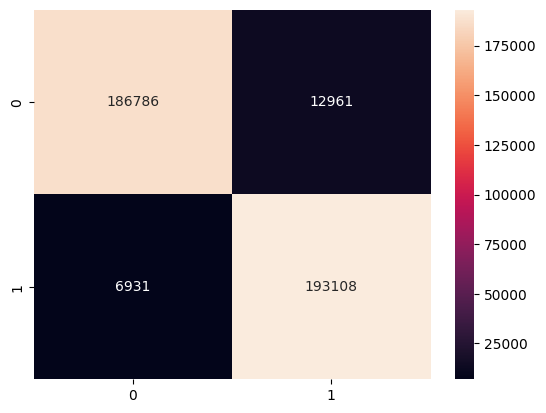

In [17]:
import seaborn as sns
# heatmap
ypred = model.predict(X_test)
ypred = ypred > 0.5
cm = confusion_matrix(y_test, ypred)
sns.heatmap(cm, annot=True, fmt='d')

In [18]:
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95    199747
           1       0.94      0.97      0.95    200039

    accuracy                           0.95    399786
   macro avg       0.95      0.95      0.95    399786
weighted avg       0.95      0.95      0.95    399786



# save the modal

In [48]:
from joblib import dump
model.save('ann_fraud_detection.h5')
dump(p, 'ann_fraud_detection_preprocessor.jb')

['ann_fraud_detection_preprocessor.jb']

# load the modal

In [49]:
from joblib import load
def load_model():
    model = tf.keras.models.load_model('ann_fraud_detection.h5')
    return model

def load_preprocessor():
    p = load('ann_fraud_detection_preprocessor.jb')
    return p

In [51]:
existing_model = load_model()
p = load_preprocessor()
# existing_model.summary()

In [52]:
def predict_fraud(model, data):
    data = p.transform(data)
    prediction = model.predict(data)
    return prediction

In [54]:
data = pd.DataFrame({
    'step': [1],
    'type': ['CASH_OUT'],
    'amount': [1000],
    'name_orig': ['C12345'],
    'oldbalanceOrg': [1000],
    'newbalanceOrig': [0],
    'name_dest': ['M12345'],
    'oldbalanceDest': [0],
    'newbalanceDest': [0],
})

out = predict_fraud(existing_model, data)
print(out[0][0] > 0.5)
    

1/1 [==============================] - 0s 17ms/step
True
